# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


# Code (w/ lib) 

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  LSTM: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  LSTM: lstm (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

In [1]:
%load_ext autoreload
%autoreload 2

from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import SVR_head
import time
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW

# path_labels = os.path.join('partA','starting_point','samples.csv')
# 'original' : os.path.join('partA','starting_point','subsamples_60_240.csv'),
path_dict ={
  
  'train' : os.path.join('partA','starting_point','train_191.csv'),
  'val' : os.path.join('partA','starting_point','val_26.csv'),
  'test' : os.path.join('partA','starting_point','test_23.csv')
}

path_dataset = os.path.join('partA','video','video')  
head = SVR_head(svr_params={'kernel':'rbf','C':1,'epsilon':10})

# print(f'\npath_labels: {path_labels}\n')

preprocess = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")

model_advanced = Model_Advanced(model_type=model_type,
                                path_dataset=path_dataset,
                                embedding_reduction=embedding_reduction,
                                clips_reduction=clips_reduction,
                                sample_frame_strategy=sample_frame_strategy,
                                stride_window=70,
                                path_labels=path_dict,
                                preprocess=preprocess,
                                batch_size=1,
                                head=head
                                ) 

c:\Users\franc\miniconda3\envs\videoMaev2_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\franc\miniconda3\envs\videoMaev2_project\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\franc\miniconda3\envs\videoMaev2_project\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\franc\Desktop\PainAssessmentVideo\VideoMAEv2\models\modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch

Set path_labels: partA\starting_point\train_191.csv


In [ ]:
# from joblib import load

# # Load the trained model
# svr_loaded = load('svr_model.joblib')
# print("Model loaded successfully.")

In [ ]:
path_dict.keys()

dict_keys(['train', 'val', 'test'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
traindataset
Set path_labels: partA\starting_point\train_191.csv


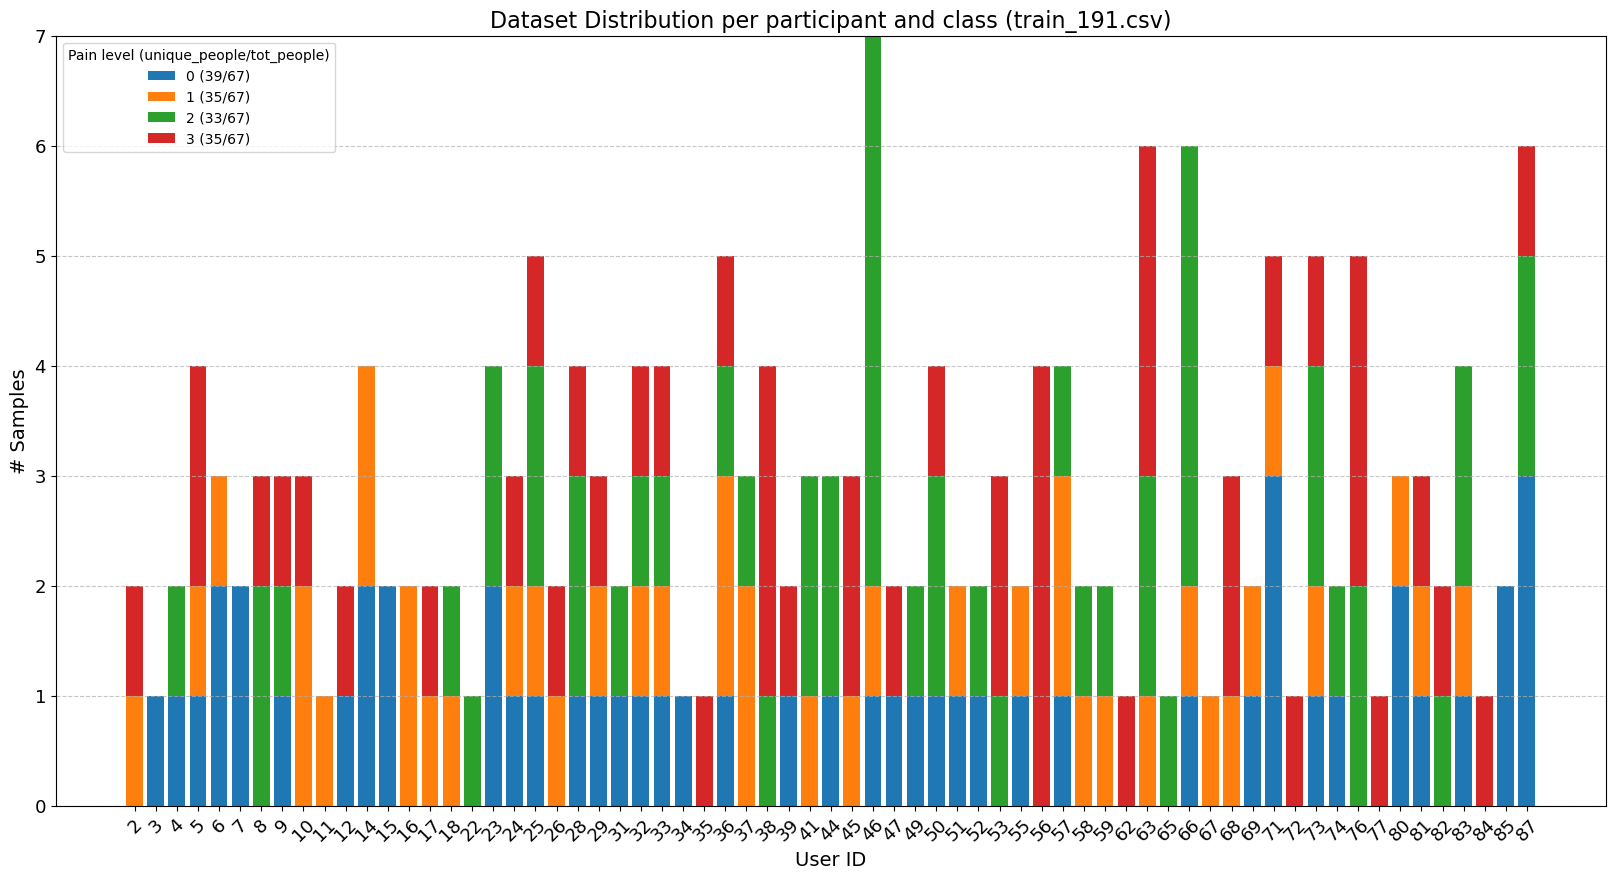

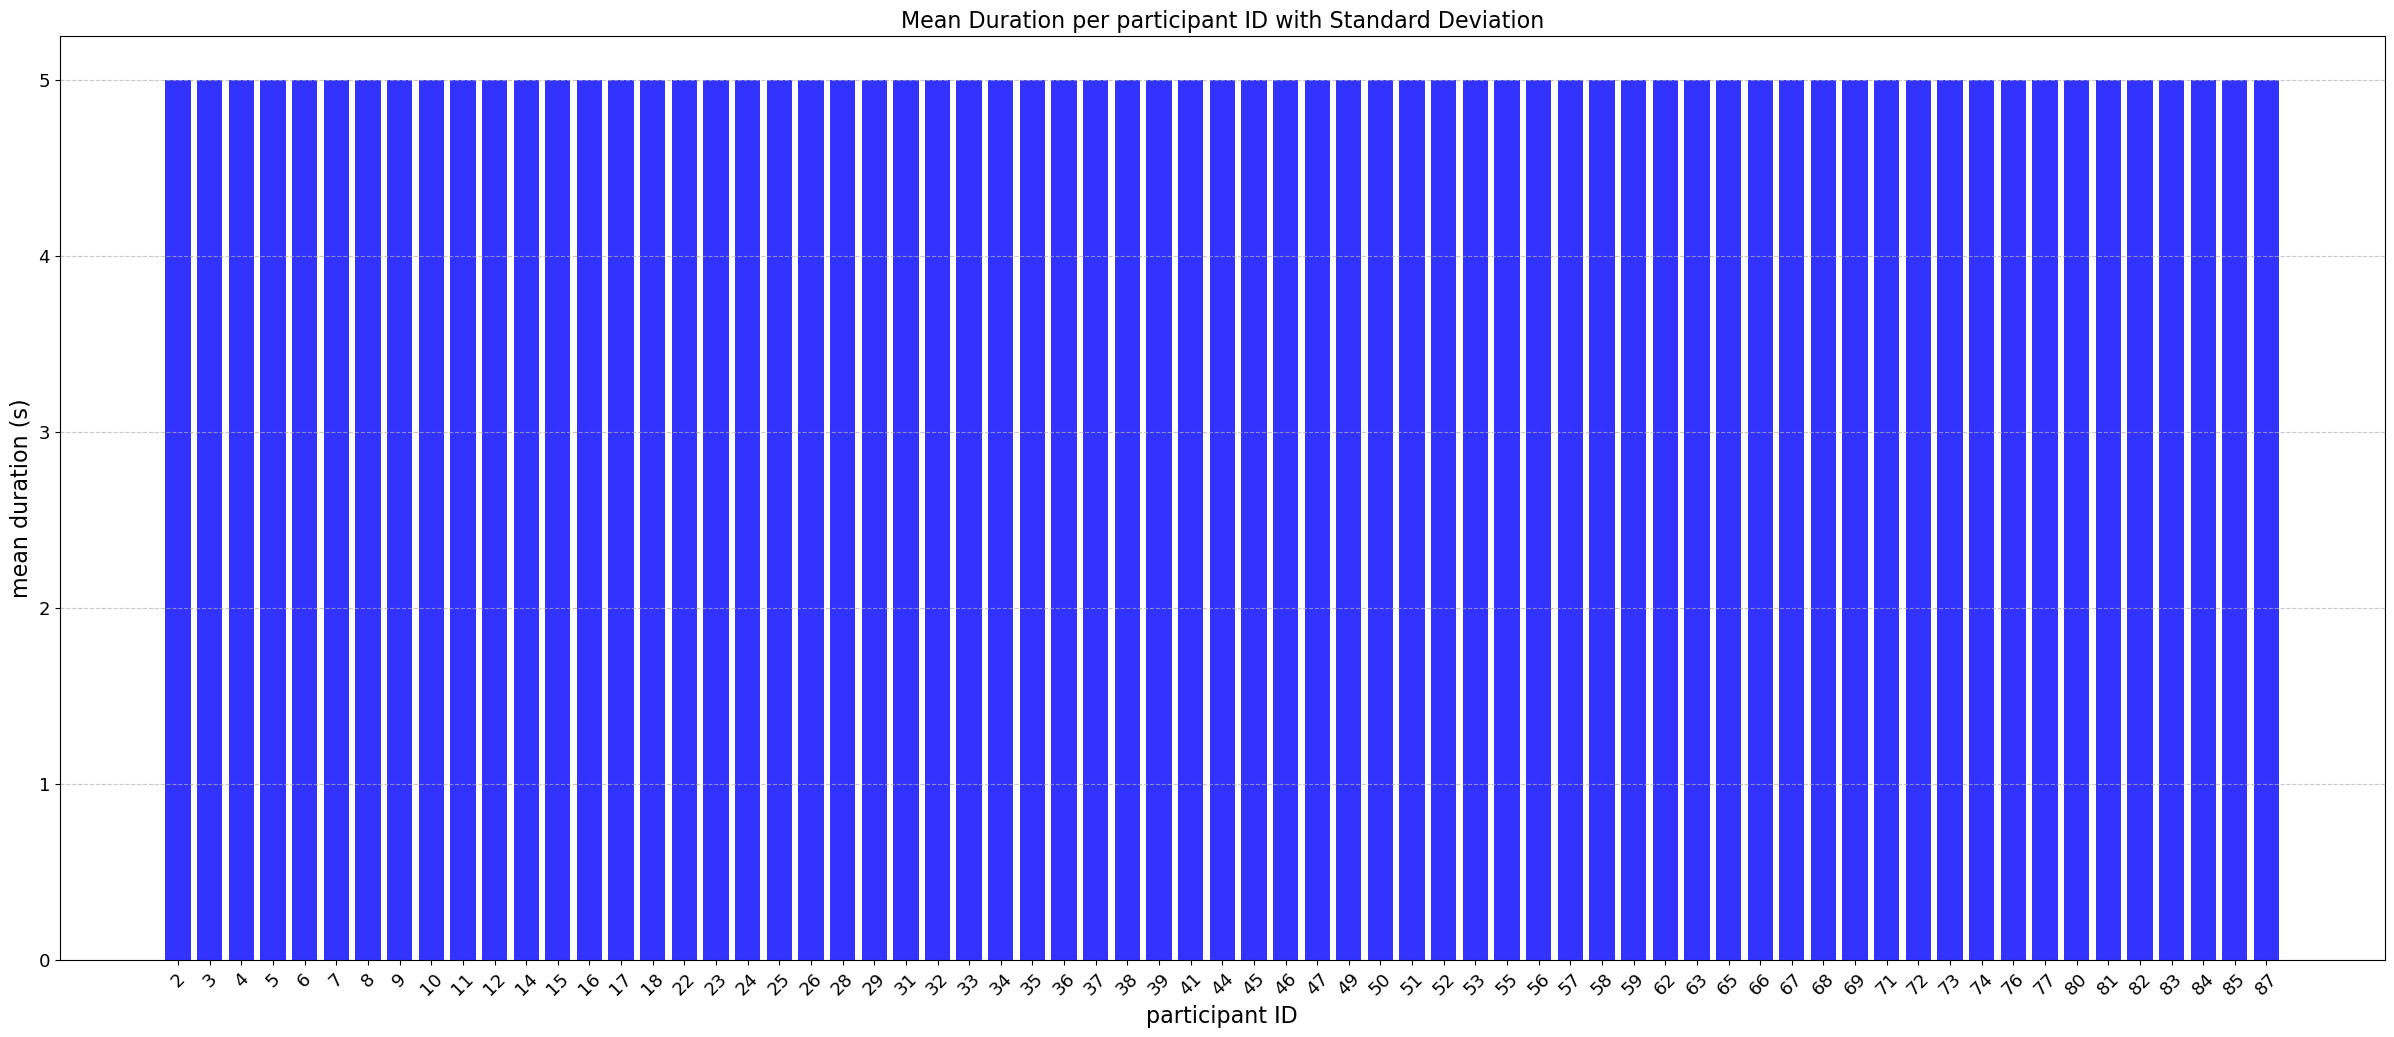

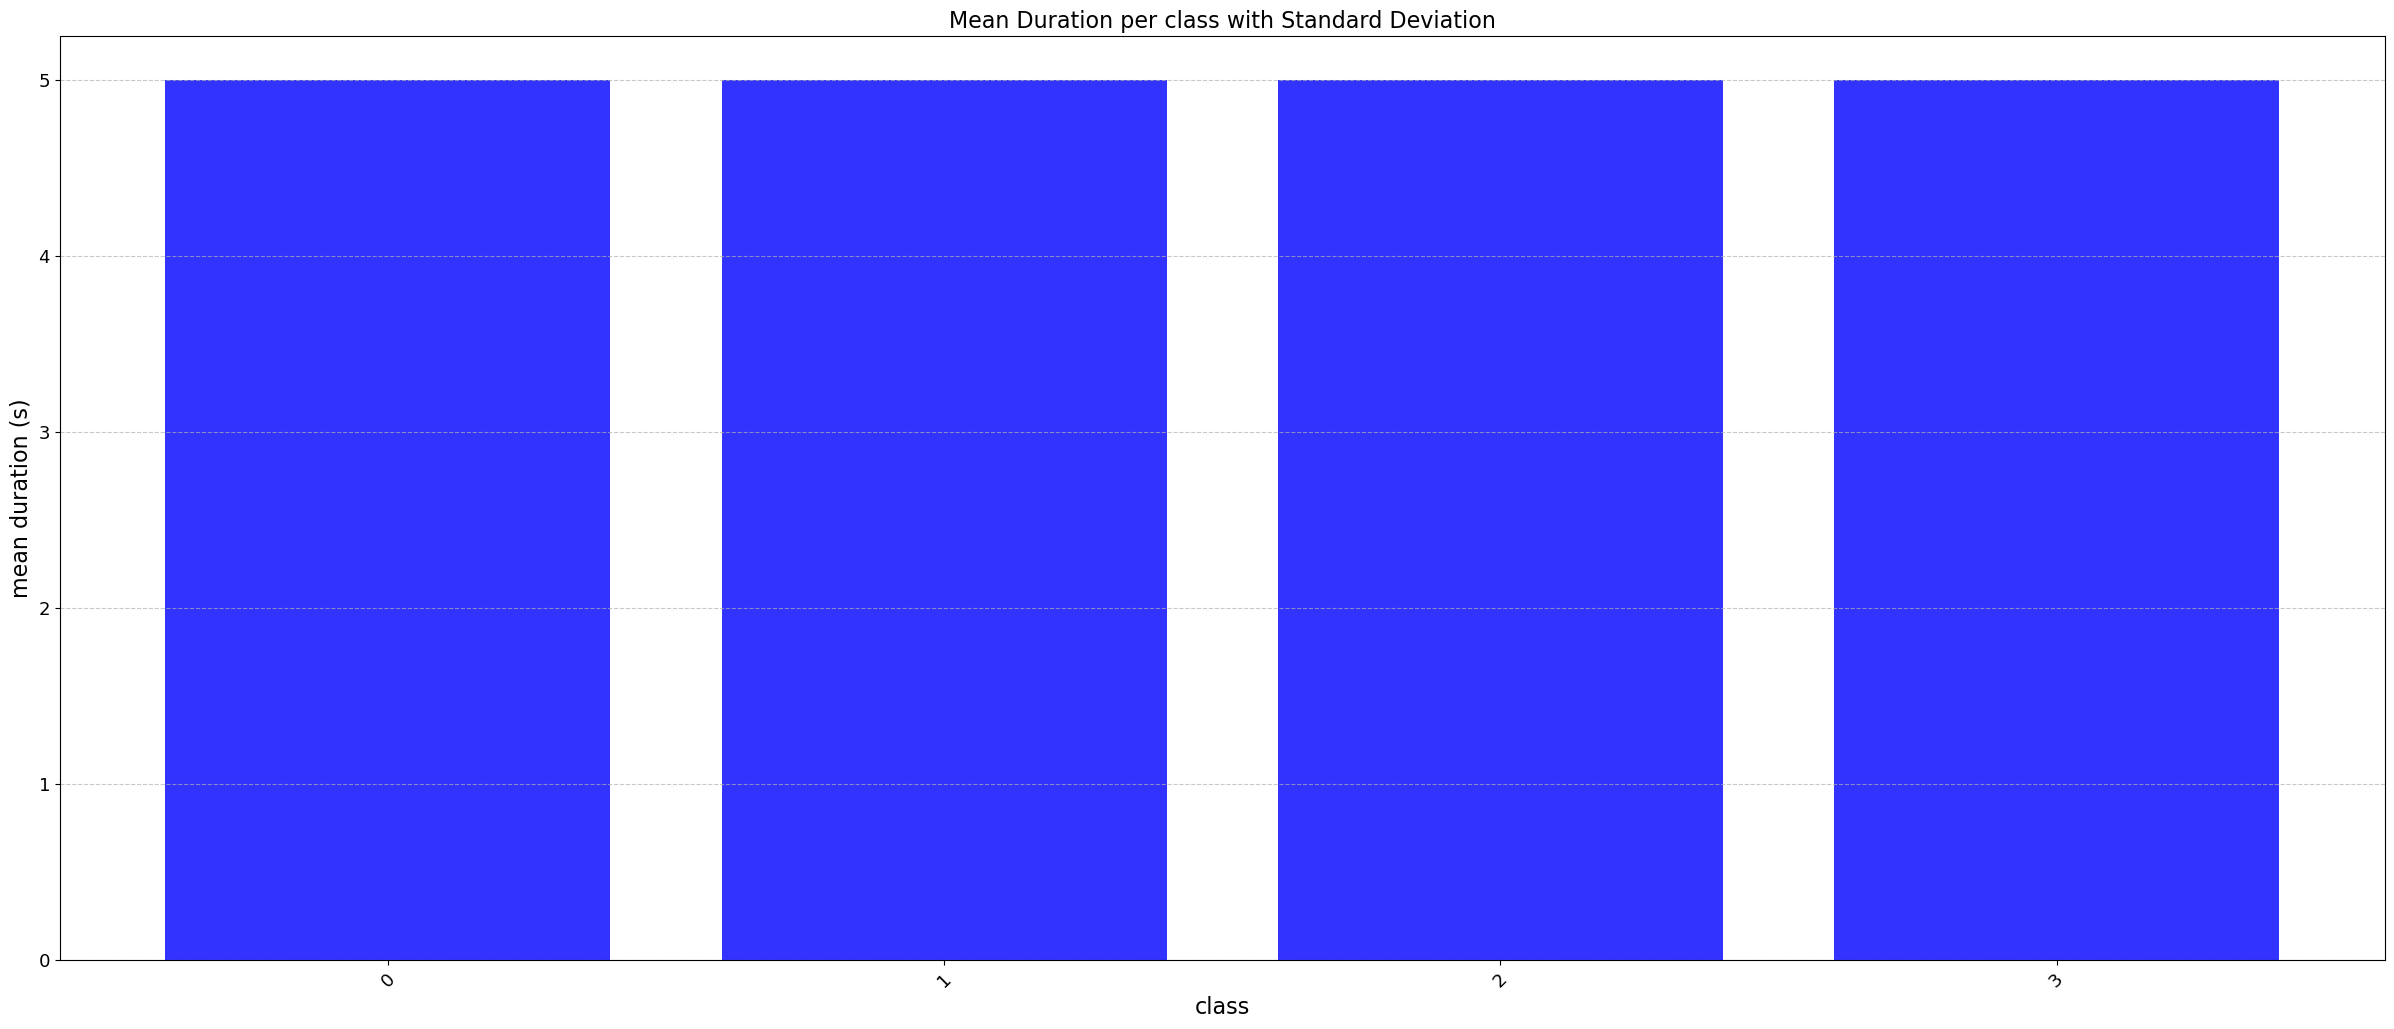

valdataset
Set path_labels: partA\starting_point\val_26.csv


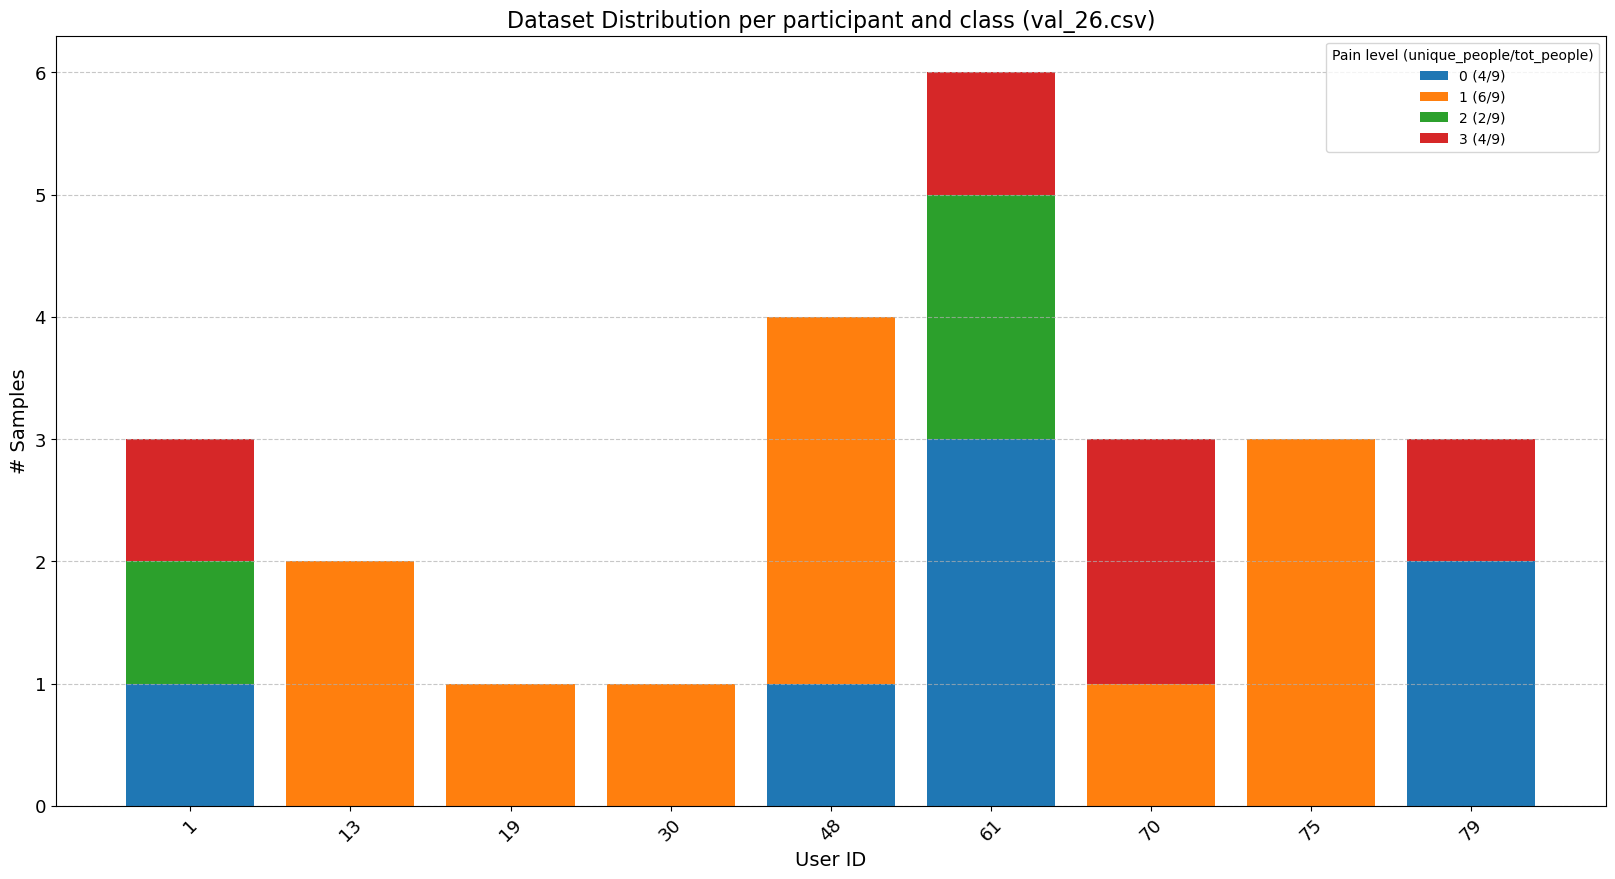

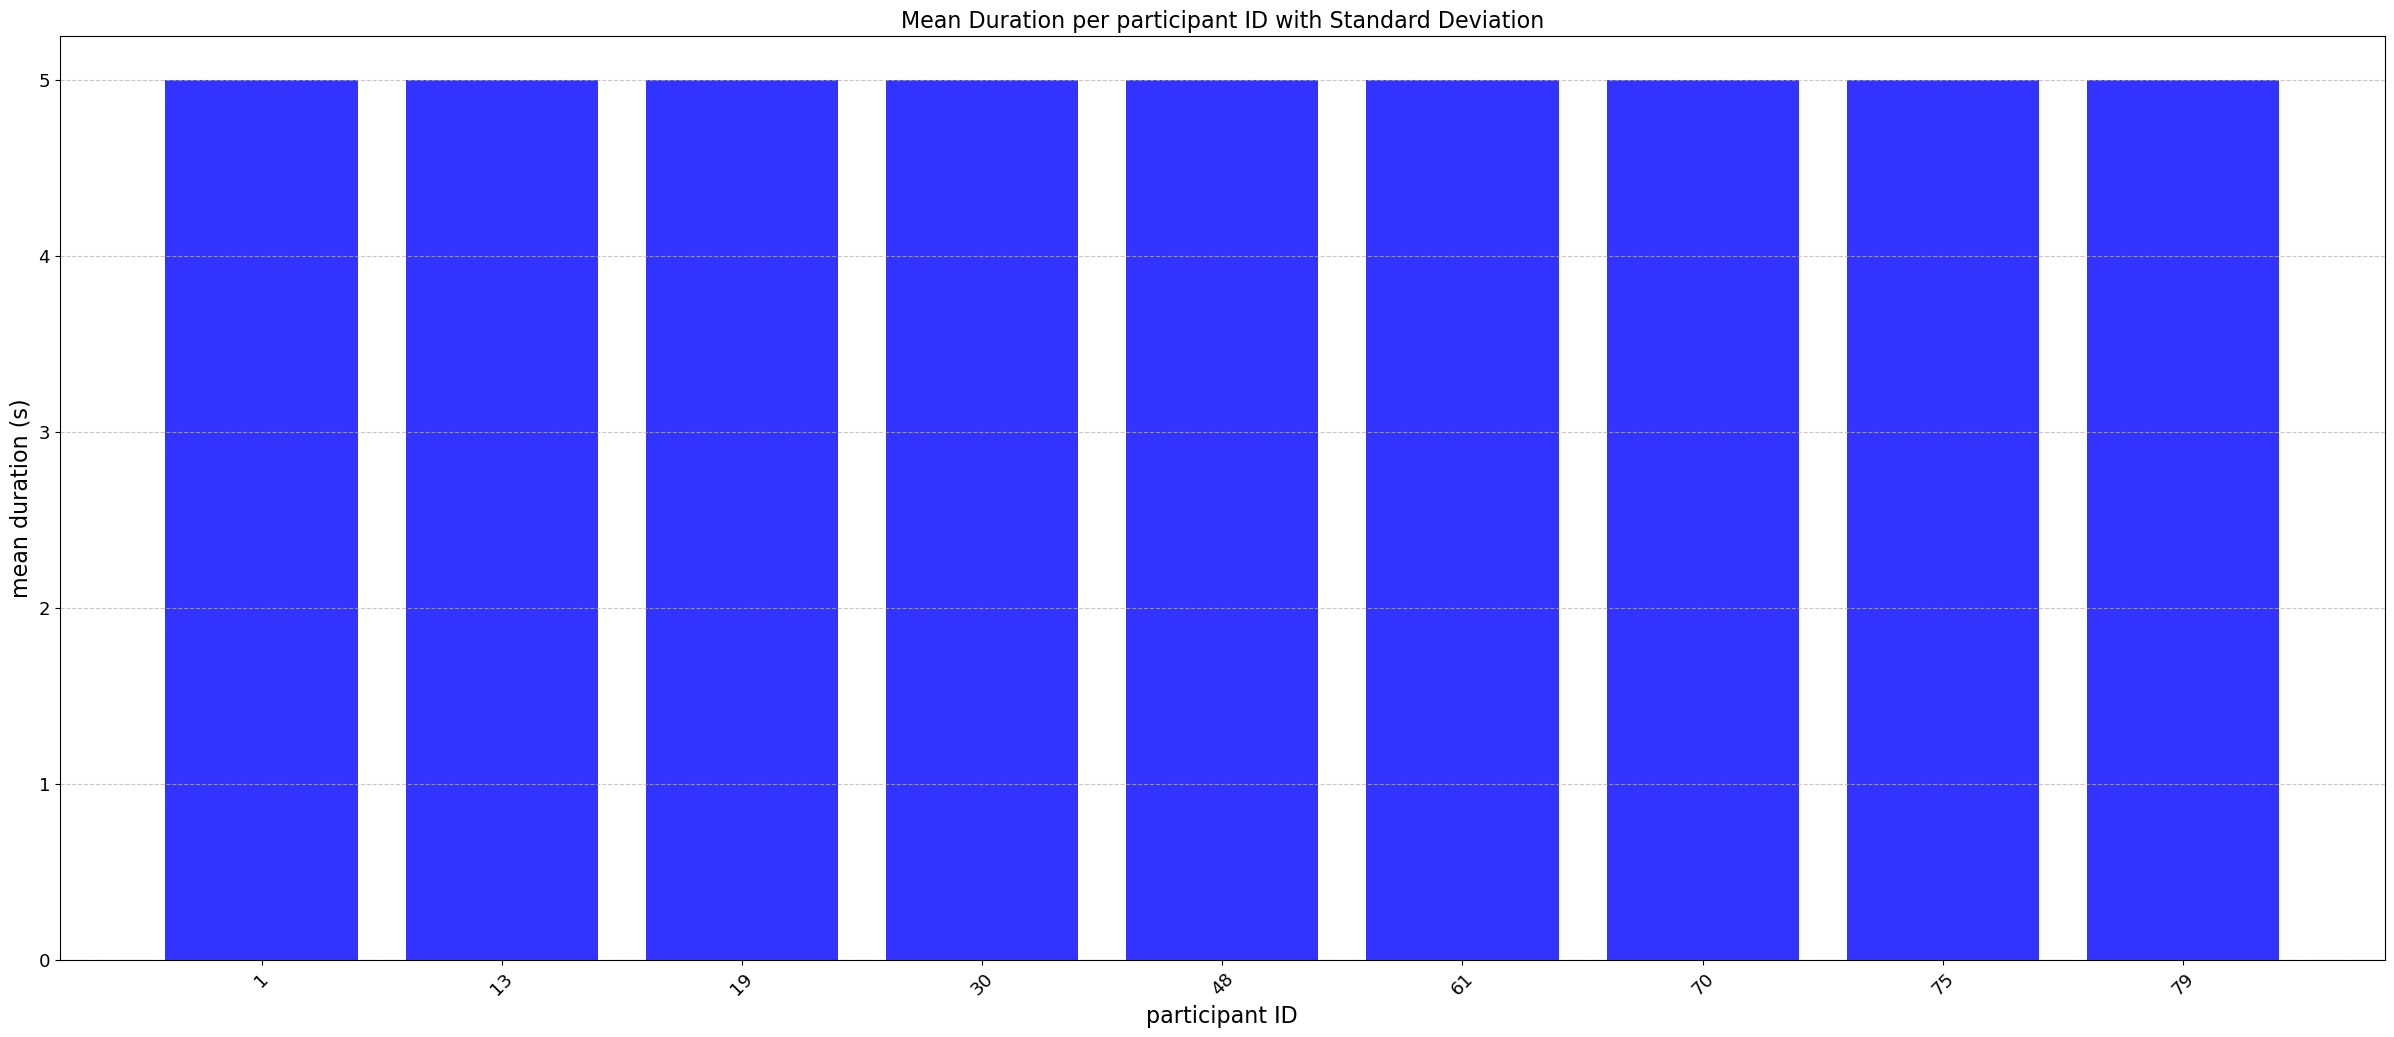

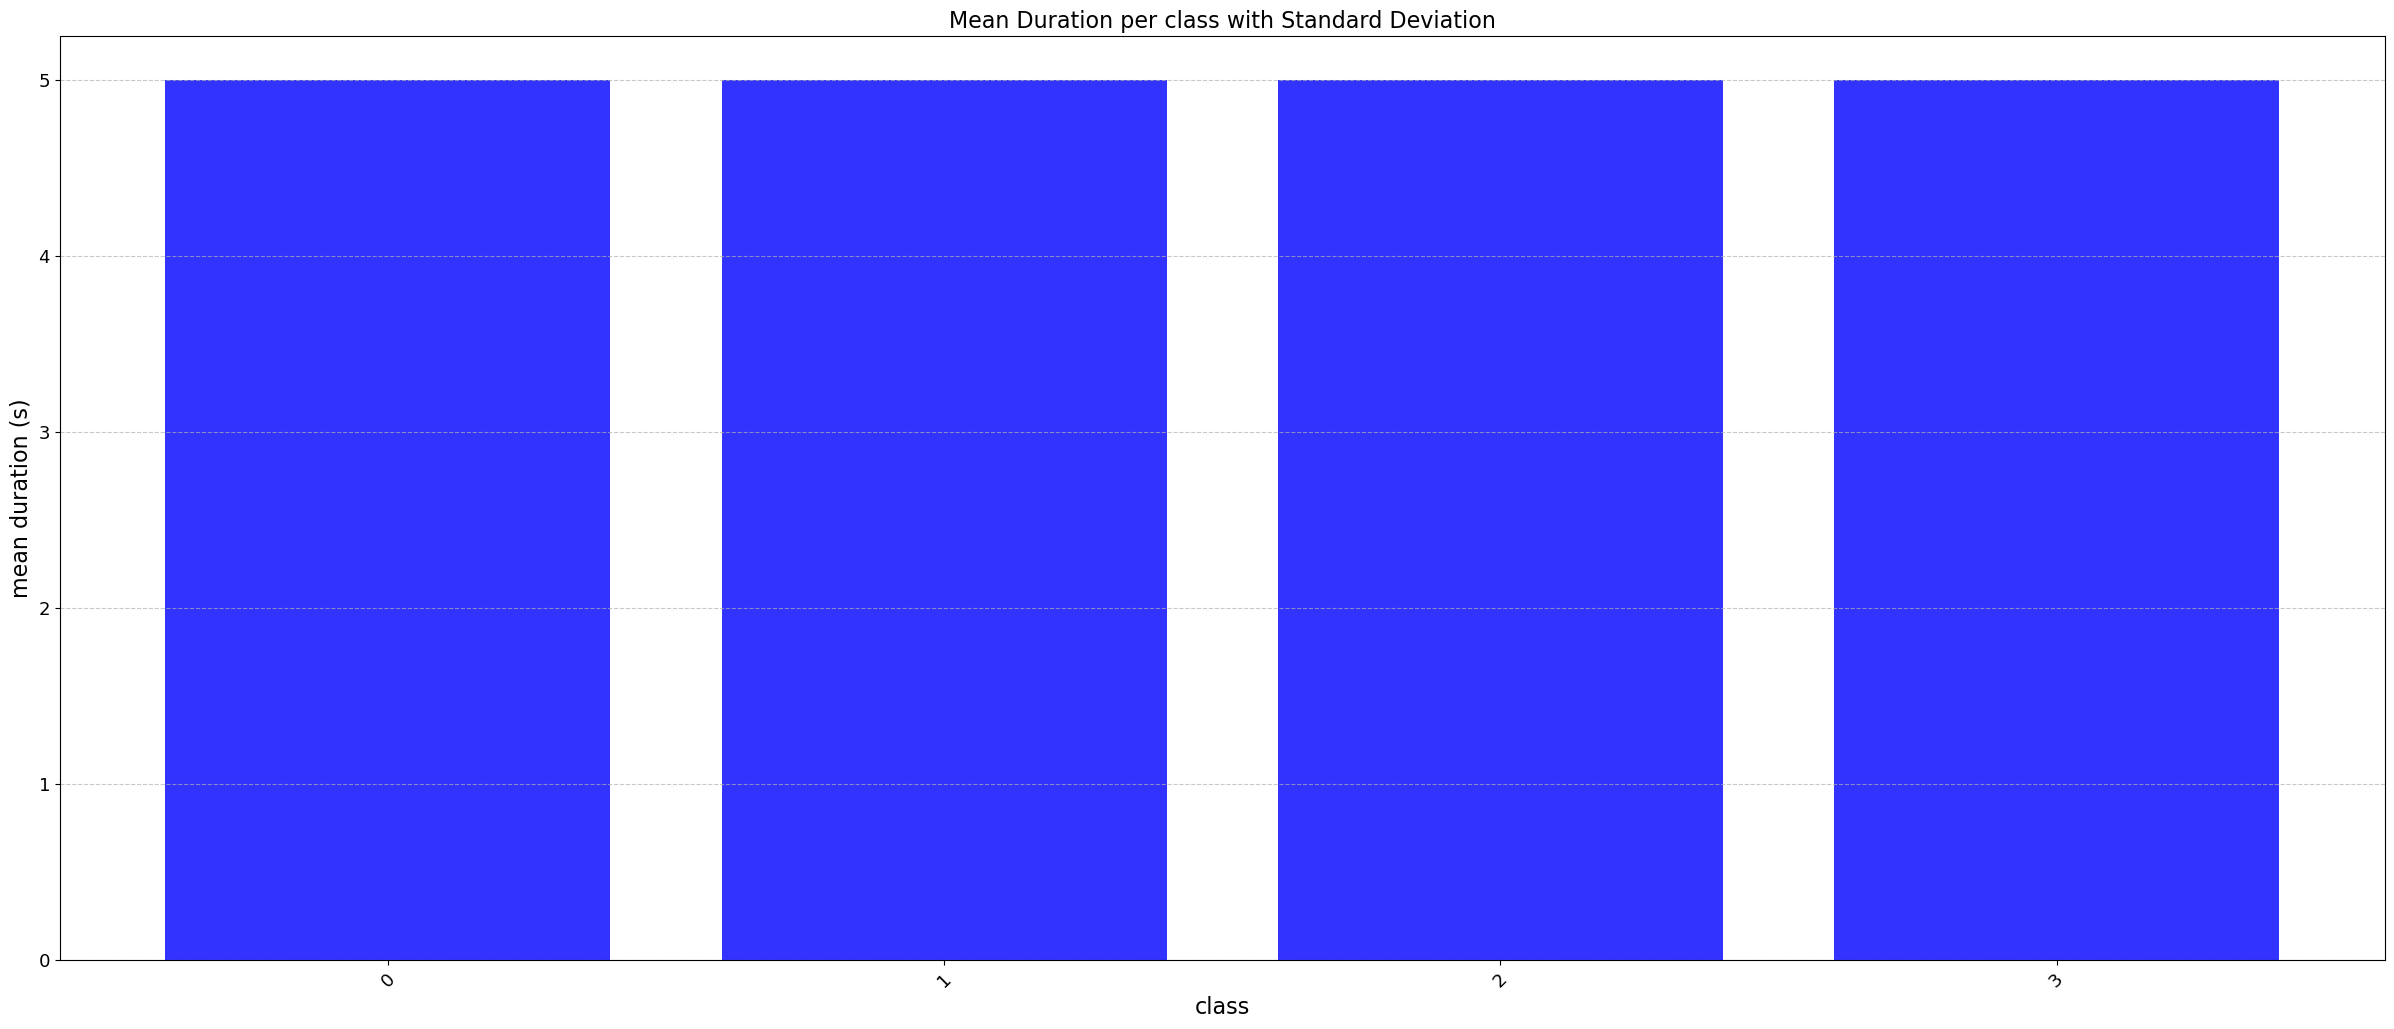

testdataset
Set path_labels: partA\starting_point\test_23.csv


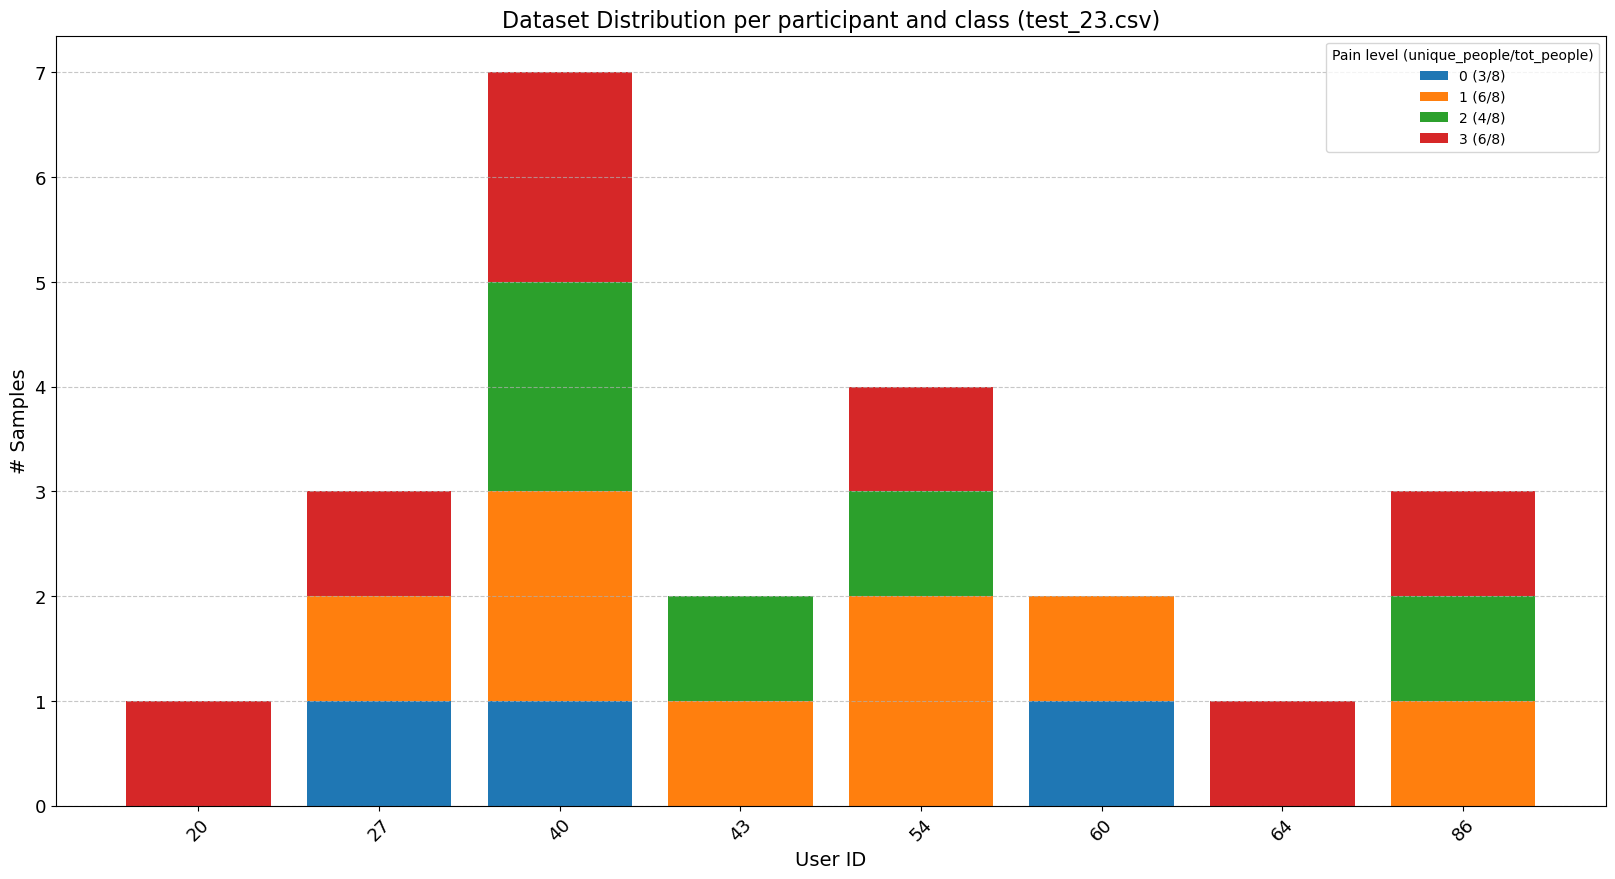

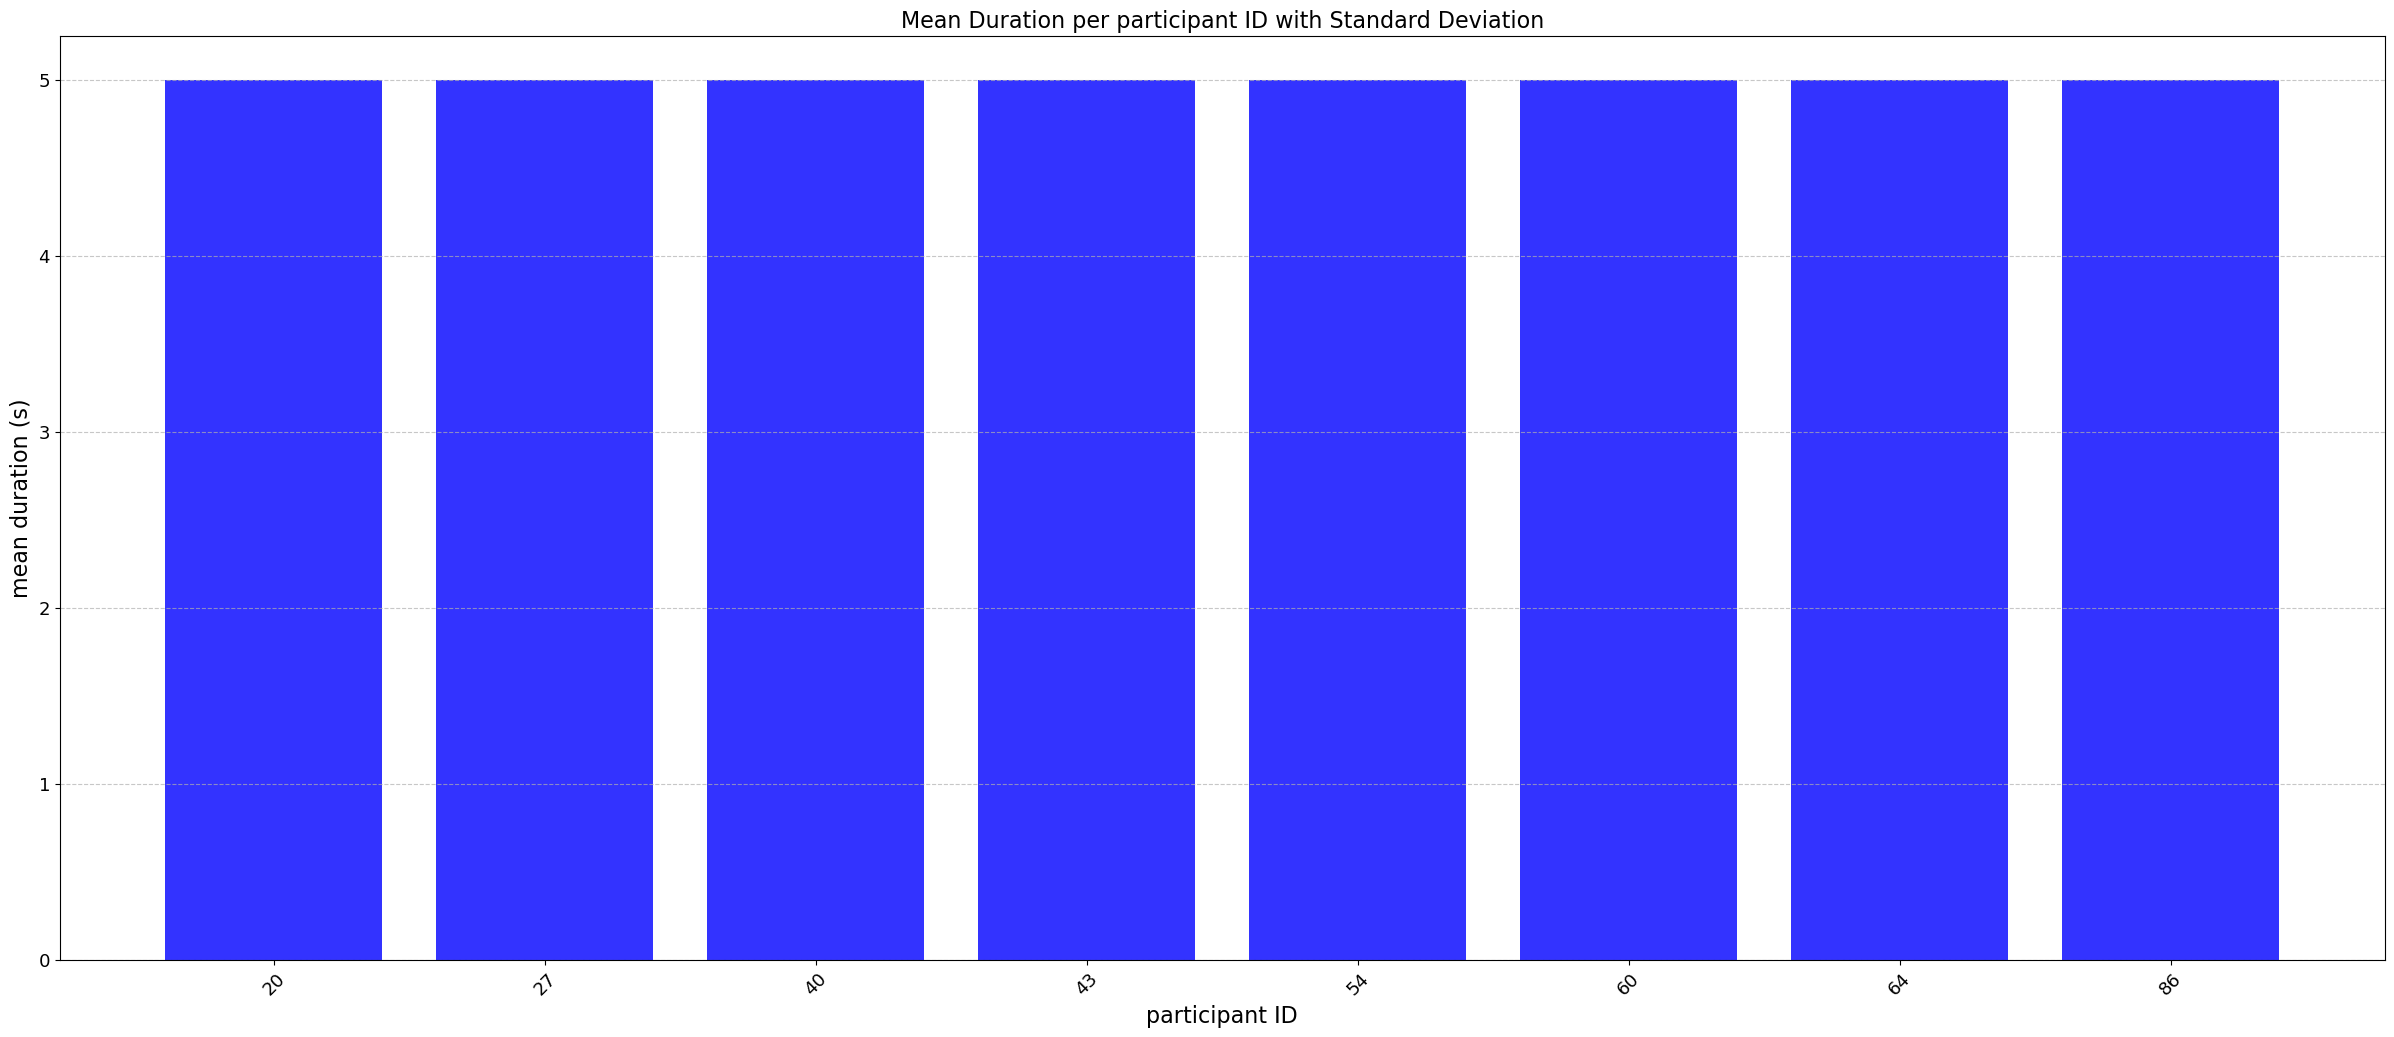

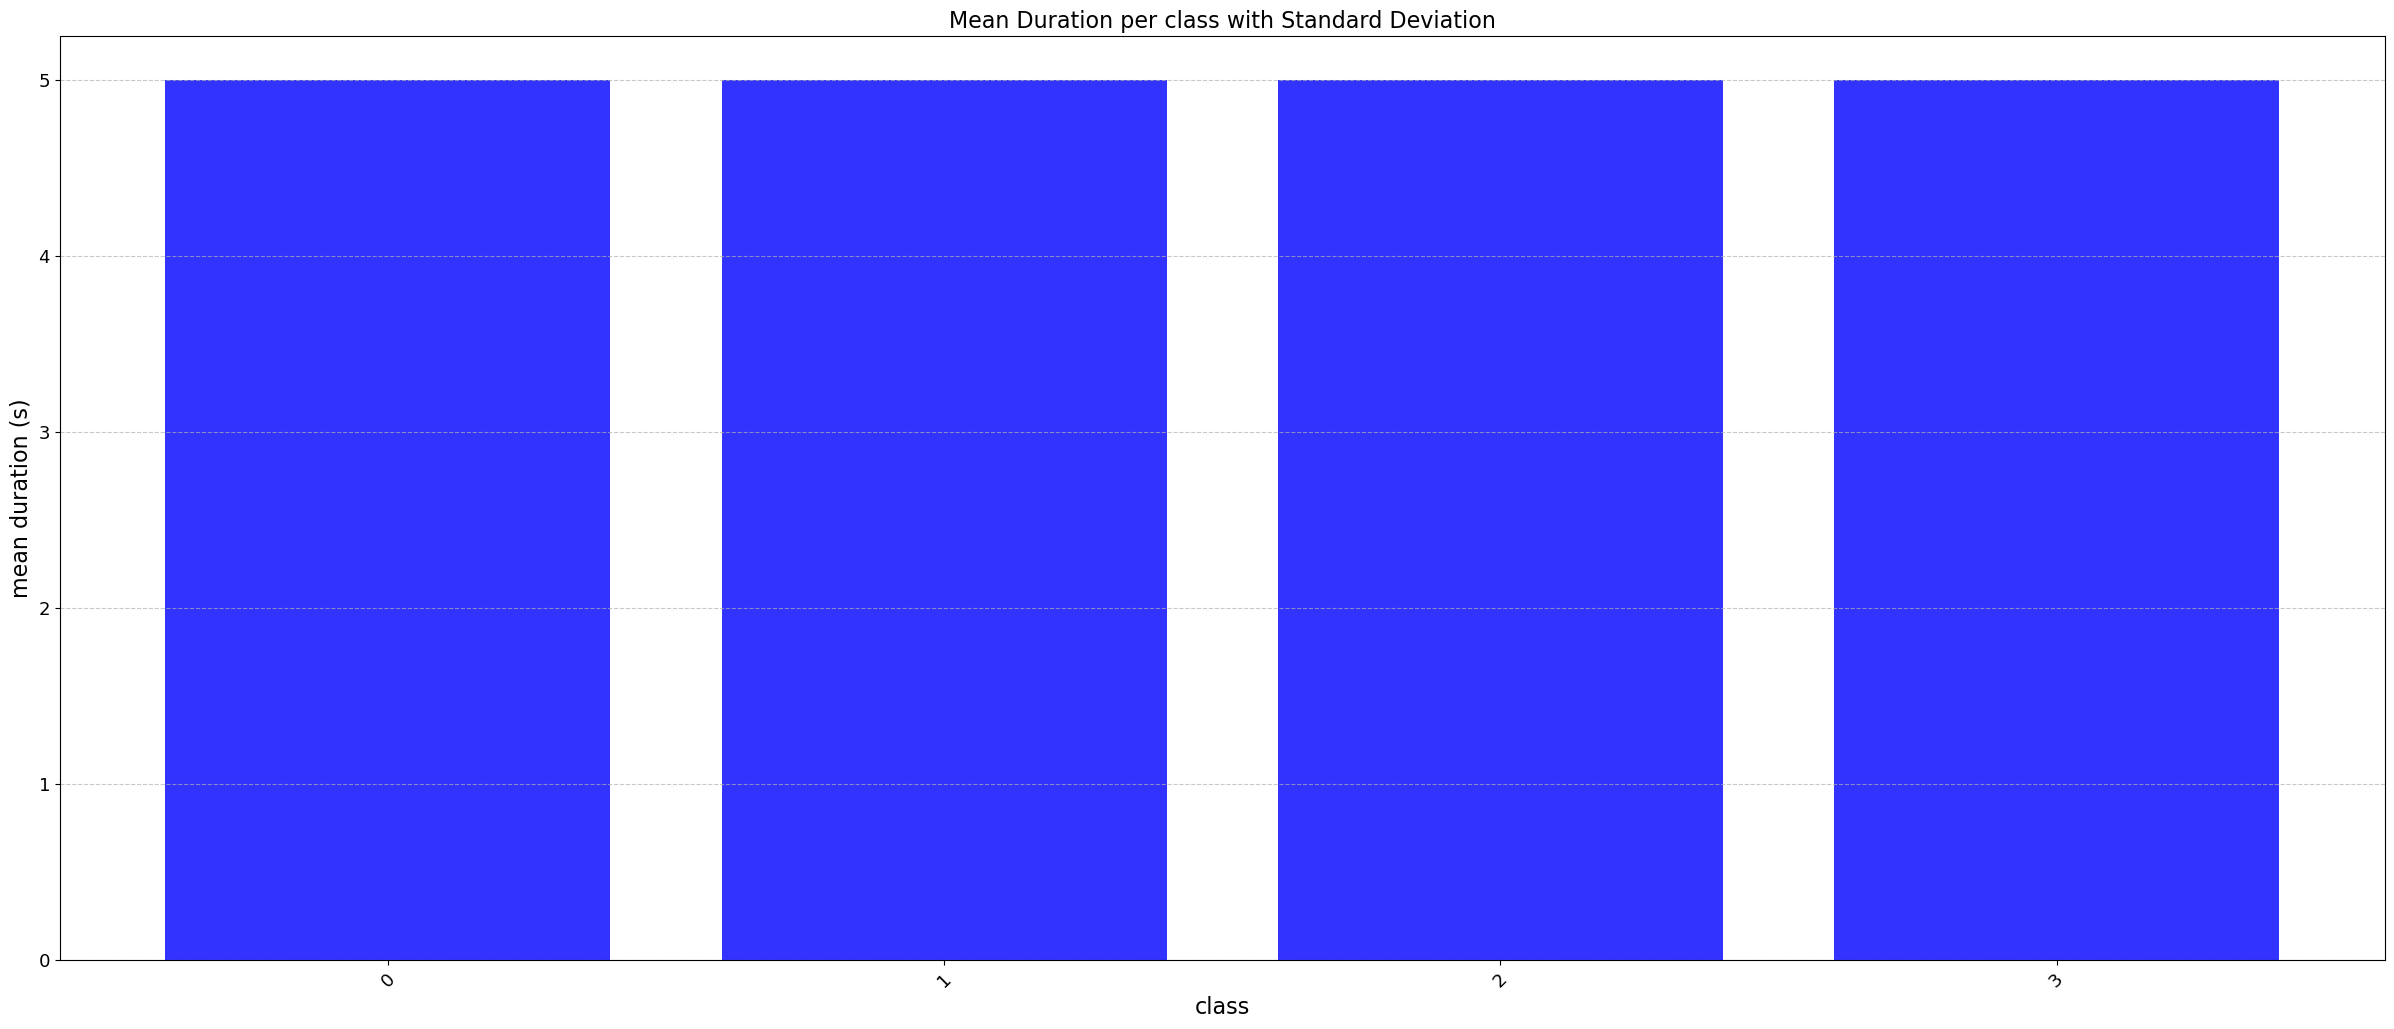

In [2]:
%load_ext autoreload
%autoreload 2

for key in path_dict.keys():
  print(key + 'dataset')
  model_advanced.dataset.set_path_labels(key)
  model_advanced.dataset.plot_dataset_distribution(per_class=True,per_partecipant=True)
  model_advanced.dataset.plot_distribution_mean_std_duration(per_class=True,per_partecipant=True)

GridSearch using SVR.-..
Set path_labels: partA\starting_point\val_26.csv
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature 

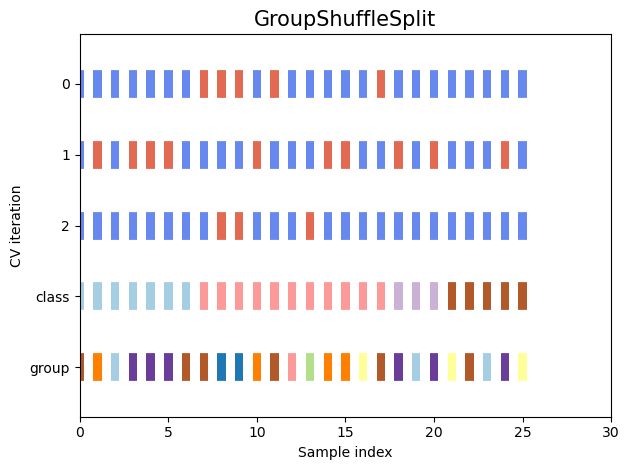

Best Parameters: {'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}
Best Score: -0.6577216551683335


In [3]:
%autoreload 2
param_grid = {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 1, 10, 100],
        }

path_validation = os.path.join('partA','starting_point','subsamples_5_20.csv')
path_training = os.path.join('partA','starting_point','subsamples_60_240.csv')

# GRID search
# model_advanced.dataset.set_path_labels(path_validation)
result = model_advanced.run_grid_search(param_grid=param_grid,k_cross_validation=3)

if result is not None:
  grid_search, list_split_indices, subjects_id, y = result
  head = SVR_head(svr_params=grid_search.best_params_)
  model_advanced.head = head

# #Training 
# model_advanced.train()

In [4]:
import pandas as pd
df = pd.DataFrame(grid_search.cv_results_)
df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.000000,0.000000,0.000000,0.000000,0.1,1.0,rbf,"{'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}",-0.238235,-0.733760,-1.001169,-0.657722,0.316073,1,-0.910953,-0.800048,-0.727382,-0.812795,0.075483
0,0.003363,0.004756,0.001339,0.001894,0.1,0.1,rbf,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}",-0.298614,-0.747070,-1.098096,-0.714593,0.327194,2,-0.921096,-0.807624,-0.756272,-0.828331,0.068863
4,0.001073,0.001517,0.000000,0.000000,1.0,0.1,rbf,"{'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}",-0.351307,-0.776639,-1.087615,-0.738521,0.301802,3,-0.854002,-0.767099,-0.696527,-0.772542,0.064404
5,0.000644,0.000455,0.000000,0.000000,1.0,1.0,rbf,"{'C': 1, 'epsilon': 1, 'kernel': 'rbf'}",-0.499368,-0.856940,-1.012143,-0.789484,0.214705,4,-0.950123,-0.865550,-0.728189,-0.847954,0.091454
2,0.000000,0.000000,0.000000,0.000000,0.1,10.0,rbf,"{'C': 0.1, 'epsilon': 10, 'kernel': 'rbf'}",-0.700000,-0.928571,-1.000000,-0.876190,0.127953,5,-1.023810,-0.973684,-0.954545,-0.984013,0.029205
3,0.000000,0.000000,0.000000,0.000000,0.1,100.0,rbf,"{'C': 0.1, 'epsilon': 100, 'kernel': 'rbf'}",-0.700000,-0.928571,-1.000000,-0.876190,0.127953,5,-1.023810,-0.973684,-0.954545,-0.984013,0.029205
6,0.000334,0.000472,0.000663,0.000469,1.0,10.0,rbf,"{'C': 1, 'epsilon': 10, 'kernel': 'rbf'}",-0.700000,-0.928571,-1.000000,-0.876190,0.127953,5,-1.023810,-0.973684,-0.954545,-0.984013,0.029205
7,0.000330,0.000467,0.000343,0.000485,1.0,100.0,rbf,"{'C': 1, 'epsilon': 100, 'kernel': 'rbf'}",-0.700000,-0.928571,-1.000000,-0.876190,0.127953,5,-1.023810,-0.973684,-0.954545,-0.984013,0.029205
10,0.000321,0.000454,0.000345,0.000488,10.0,10.0,rbf,"{'C': 10, 'epsilon': 10, 'kernel': 'rbf'}",-0.700000,-0.928571,-1.000000,-0.876190,0.127953,5,-1.023810,-0.973684,-0.954545,-0.984013,0.029205
11,0.000306,0.000433,0.000695,0.000501,10.0,100.0,rbf,"{'C': 10, 'epsilon': 100, 'kernel': 'rbf'}",-0.700000,-0.928571,-1.000000,-0.876190,0.127953,5,-1.023810,-0.973684,-0.954545,-0.984013,0.029205


In [5]:
import pandas as pd

# Load the CSV files
subsamples_1 = pd.read_csv('partA/starting_point/test_23.csv', sep='\t')
subsamples_2 = pd.read_csv('partA/starting_point/train_191.csv', sep='\t')

col_to_check = 'subject_id'
# Extract the 4th element from each row
elements_1 = subsamples_1[col_to_check]
elements_2 = subsamples_2[col_to_check]

# Check for common elements
common_elements = elements_1[elements_1.isin(elements_2)]

if not common_elements.empty:
  print("There are common elements:")
else:
  print("There are no common elements.")

# List of elements in common
common_elements_list = common_elements.tolist()
print("Elements in common:", common_elements_list)


There are no common elements.
Elements in common: []


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training using SVR...
Set path_labels: partA\starting_point\val_26.csv
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size(

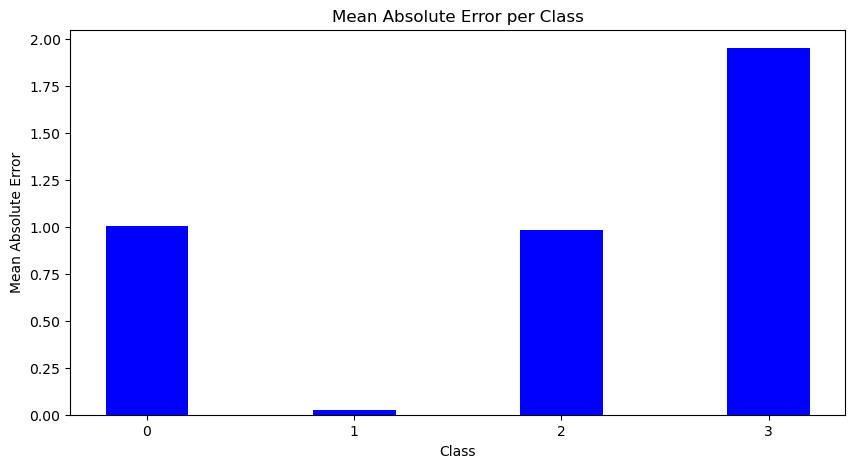

subject_ids [79 48  1 61 61 61 79 75 13 13 48 75 30 19 48 48 70 75 61  1 61 70 79  1
 61 70]


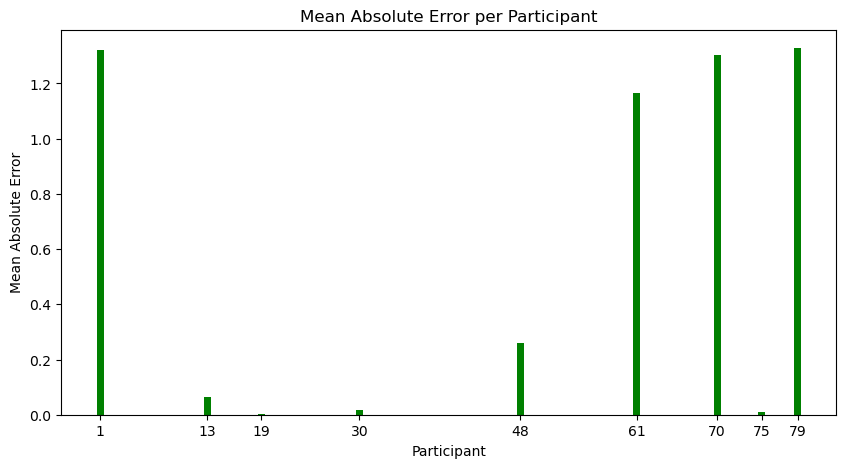

Time to complete: 21.951525449752808 seconds


In [ ]:
%load_ext autoreload
%autoreload 2

start_time = time.time()
model_advanced.train()
end_time = time.time()
print(f'Time to complete: {end_time-start_time} seconds')
# list_frames = model_advanced.fit(stop_after=3,plot_dataset_split_distribution=True)
# list_frames


[['79\t112016_m_25\t0\tBL1\t7812\t112016_m_25-BL1-092']
 ['48\t100214_m_50\t0\tBL1\t4719\t100214_m_50-BL1-099']
 ['1\t071309_w_21\t0\tBL1\t6\t071309_w_21-BL1-086']
 ['61\t101809_m_59\t0\tBL1\t6011\t101809_m_59-BL1-091']
 ['61\t101809_m_59\t0\tBL1\t6020\t101809_m_59-BL1-100']
 ['61\t101809_m_59\t0\tBL1\t6007\t101809_m_59-BL1-087']
 ['79\t112016_m_25\t0\tBL1\t7819\t112016_m_25-BL1-099']
 ['75\t111409_w_63\t1\tPA1\t7422\t111409_w_63-PA1-006']
 ['13\t080209_w_26\t1\tPA1\t1231\t080209_w_26-PA1-044']
 ['13\t080209_w_26\t1\tPA1\t1236\t080209_w_26-PA1-063']
 ['48\t100214_m_50\t1\tPA1\t4724\t100214_m_50-PA1-006']
 ['75\t111409_w_63\t1\tPA1\t7440\t111409_w_63-PA1-080']
 ['30\t082809_m_26\t1\tPA1\t2935\t082809_m_26-PA1-048']
 ['19\t080714_m_23\t1\tPA1\t1826\t080714_m_23-PA1-025']
 ['48\t100214_m_50\t1\tPA1\t4721\t100214_m_50-PA1-001']
 ['48\t100214_m_50\t1\tPA1\t4726\t100214_m_50-PA1-009']
 ['70\t102514_w_40\t1\tPA1\t6931\t102514_w_40-PA1-052']
 ['75\t111409_w_63\t1\tPA1\t7435\t111409_w_63-PA1-05

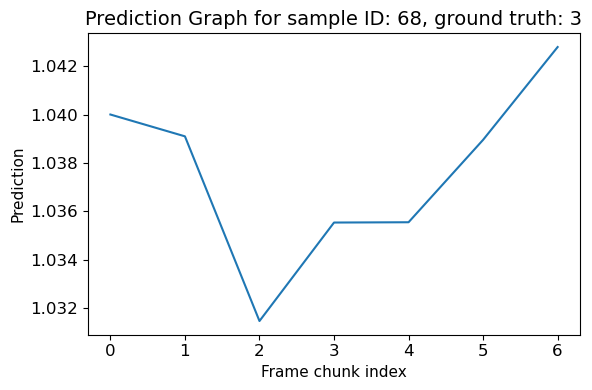

csv ['1' '071309_w_21' '3' 'PA3' '68' '071309_w_21-PA3-024']
input_video_path partA\video\video\071309_w_21\071309_w_21-PA3-024.mp4
all_labels [tensor([3, 3, 3, 3, 3, 3, 3], dtype=torch.int16)]
input_video_path: partA\video\video\071309_w_21\071309_w_21-PA3-024.mp4
frame_count: 138
frame_indices: 1
frame_indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11

In [19]:
# model_advanced.dataset.set_path_labels('test')
# model_advanced.train()
# print('Plot prediction graph')
model_advanced.plot_prediction_graph(68,stride_window=20)


In [17]:
model_advanced.plot_prediction_graph_all([6,6011],stride_window=60)

Sliding shape torch.Size([3, 16])
features[1]->labels tensor([[0, 0, 0]], dtype=torch.int16)
Sliding shape torch.Size([3, 16])
features[1]->labels tensor([[0, 0, 0]], dtype=torch.int16)
all_labels [tensor([0, 0, 0], dtype=torch.int16), tensor([0, 0, 0], dtype=torch.int16)]
input_video_path: partA\video\video\071309_w_21\071309_w_21-BL1-086.mp4
frame_count: 138
frame_indices: 2
frame_indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
frame_indices: [ 0  1  2  3  4  5  6

[array([1.03822137, 1.04202403, 1.04440803]),
 array([0.9973145 , 1.00508893, 1.00435402])]

In [12]:
for train, test in cp:
  intersection = set(train).intersection(set(test))
  if not intersection:
    print("Intersection is empty")
  else:
    print(f"Intersection is not empty: {intersection}")

Intersection is empty
Intersection is empty
Intersection is empty


In [22]:
results

[(array([ 1,  2,  3,  4,  5,  7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         21, 23, 24, 25], dtype=int64),
  array([ 0,  6,  8,  9, 22], dtype=int64)),
 (array([ 0,  1,  3,  4,  5,  6,  8,  9, 10, 12, 13, 14, 15, 16, 18, 20, 21,
         22, 24, 25], dtype=int64),
  array([ 2,  7, 11, 17, 19, 23], dtype=int64)),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25], dtype=int64),
  array([12, 13], dtype=int64))]

In [14]:
import pandas as pd

model_advanced.dataset.set_path_labels('test')
start_time = time.time()
results = model_advanced.train(k_cross_validation=3)
end_time = time.time()

# # Sort the DataFrame by 'rank_test_score'
# df = pd.DataFrame(results.cv_results_)
# df_sorted = df.sort_values(by='rank_test_score')
# df_sorted

Set path_labels: partA\starting_point\test_23.csv
Training using SVR with k-fold cross-validation...
extracting features using... cuda
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Sliding shape torch.Size([2, 16])
Feature extracetion done
X.shape (23, 768)
y.shapey (23,)
Keys: dict_keys(['fit_tim

In [28]:
results_df = pd.DataFrame(results[1])
results_df['test_score'] = -results_df['test_score']
results_df['train_score'] = -results_df['train_score']
results_df.insert(results_df.columns.get_loc('estimator') + 1, 'kernel', results_df['estimator'].apply(lambda x: x.kernel))
results_df

,fit_time,score_time,estimator,kernel,test_score,train_score
0,0.0,0.0,"SVR(C=1, epsilon=10)",rbf,0.833333,1.000000
1,0.0,0.0,"SVR(C=1, epsilon=10)",rbf,0.833333,0.950000
2,0.0,0.0,"SVR(C=1, epsilon=10)",rbf,1.250000,0.868421


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SETTINGS:
model_type: MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction: EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
sample_frame_strategy: SAMPLE_FRAME_STRATEGY.RANDOM_SAMPLING
clips_reduction: CLIPS_REDUCTION.MEAN
path_labels: os.path.join('partA','starting_point','subsamples_100_400.csv')
path_dataset: os.path.join('partA','video','video')
svr_params: {'kernel':'rbf','C':1,'epsilon':0.1}

SUBSAMPLES_100_400 SINGLE_FIT
Mean absolute Error: 0.9627701396658619
missclassified: 42
Time to complete: 532.8504619598389 seconds

SUBSAMPLES_100_400 K-CROSS-VALIDATION
extracting features using... cuda
Feature extracetion done
X.shape (400, 768)
y.shapey (400,)
Cross-validation scores (MAE): [0.99069627 1.00124759 0.96343781 0.9991555  0.93614986]
Mean cross-validation score (MAE): 0.9781374056545851
Std cross-validation score (MAE): 0.024950342420264733
Time to complete: 298.28600120544434

SUBSAMPLES_30_120 K-CROSS-VALIDATION
Dataset path: partA\video\video
extracting features using... cuda
Feature extracetion done
X.shape (120, 768)
y.shapey (120,)
Cross-validation scores (MAE): [1.04056675 0.98878955 1.04054796]
Mean cross-validation score (MAE): 1.0233014194524357
Std cross-validation score (MAE): 0.024403577083218192
87.271644115448


In [ ]:
# %autoreload 2
# model_advanced.dataset._generate_csv_subsampled(nr_samples_per_class=100)

number of classes: 4, 
total number of samples: 400
samples_subsampled: [['61' '101809_m_59' '0' 'BL1' '6013' '101809_m_59-BL1-093']
 ['83' '112809_w_23' '0' 'BL1' '8202' '112809_w_23-BL1-082']
 ['27' '082315_w_60' '0' 'BL1' '2611' '082315_w_60-BL1-091']
 ...
 ['39' '091914_m_46' '3' 'PA3' '3875' '091914_m_46-PA3-050']
 ['77' '111914_w_63' '3' 'PA3' '7671' '111914_w_63-PA3-043']
 ['64' '101916_m_40' '3' 'PA3' '6367' '101916_m_40-PA3-038']]
Subsampled video labels saved to partA\starting_point\subsamples_100_400.csv


# Old

In [ ]:
import torch
import os
# Ensure the file path is correct and the file is accessible
file_path = os.path.join(list_frames[1]['path'][0])
file_path = os.path.join('partA','video','video','071309_w_21','071309_w_21-PA4-042.mp4')
print(f'file_path: {file_path}')
indices = (list_frames[0]['frame_list']).detach().cpu().numpy()
id=sample_frame_strategy.value+'_'+os.path.split(file_path)[-1]
save_path = os.path.join('partA','video','custom_video',id)
tmp = []
for idx in indices:
  tmp.append(idx)
print(os.getcwd())
if os.path.exists(file_path):
	model_advanced.dataset.save_frames_as_video(file_path,indices,save_path)
else:
	print(f"File not found: {file_path}")


file_path: partA\video\video\071309_w_21\071309_w_21-PA4-042.mp4


NameError: name 'list_frames' is not defined

In [14]:
import torch

random_tensor = torch.randn(1, 3, 16, 224, 224)
print(random_tensor.shape)

torch.mean(random_tensor, dim=(0,1)).shape

torch.Size([1, 3, 16, 224, 224])


torch.Size([16, 224, 224])

# Code (w/o lib)

In [4]:
%load_ext autoreload
# %pip install triton==2.0.0
# %pip install timm==0.4.12

In [ ]:
import requests
import os
# MODEL={
#   'VideoMAEv2-Small':'',
#   'VideoMAEv2-Base':'',
#   'VideoMAEv2-'}
def import_model(model_name):  
  url = "https://huggingface.co/OpenGVLab/VideoMAE2/resolve/main/distill/vit_b_k710_dl_from_giant.pth"
  weights_path = os.path.join("pretrained",url.split('/')[-1])  # Specify a path to save the downloaded weights
  if not os.path.exists(os.path.join('pretrained','vit_b_k710_dl_from_giant.pth')):
    print("Downloading the weights...")
    # Download the file from the given URL
    response = requests.get(url, stream=True) # Stream the download for large files
    with open(weights_path, 'wb') as f:
      for chunk in response.iter_content(chunk_size=8192): # Download in chunks
        if chunk:
          f.write(chunk)
    print(f"Weights downloaded in {weights_path}")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from transformers import AutoImageProcessor
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import av
import os
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0)

class customDataset(torch.utils.data.Dataset):
  def __init__(self,path_dataset, path_labels, preprocess):
    self.path_dataset = path_dataset
    self.preprocess = preprocess
    self.video_labels = pd.read_csv(path_labels)
  
  def __len__(self):
    return len(self.video_labels)
  
  def __getitem__(self, idx):
    csv_array = self.video_labels.iloc[idx,0].split('\t') # ["subject_id, subject_name, class_id, class_name, sample_id, sample_name"]
    video_path = os.path.join(self.path_dataset, csv_array[1], csv_array[5])
    video_path += '.mp4'
    # print(video_path)
    container = av.open(video_path)
    indices = _sample_frame_indices(clip_len=16, frame_sample_rate=2, seg_len=container.streams.video[0].frames)
    frames_list=[_read_video_pyav(container, indice) for indice in indices]
    # frames = read_video_pyav(container, indices)
    # print(f'frame shape: {frames.shape}')
    num_frames = len(frames_list)
    path = np.repeat(video_path, num_frames)
    labels = np.repeat(csv_array[2], num_frames)
    preprocess_tensors = torch.stack([self.preprocess(list(frames), return_tensors="pt")['pixel_values'] for frames in frames_list])
    return  {'preprocess':preprocess_tensors,'labels': labels,'path': path}

  def _read_video_pyav(container, indices):
      '''
      Decode the video with PyAV decoder.
      Args:
          container (`av.container.input.InputContainer`): PyAV container.
          indices (`List[int]`): List of frame indices to decode.
      Returns:
          result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
      '''
      frames = []
      container.seek(0)
      start_index = indices[0]
      end_index = indices[-1]
      for i, frame in enumerate(container.decode(video=0)):
          if i > end_index:
              break
          if i >= start_index and i in indices:
              frames.append(frame)
      return np.stack([x.to_ndarray(format="rgb24") for x in frames])


  def _sample_frame_indices(clip_len, frame_sample_rate, seg_len):
      '''
      Sample a given number of frame indices from the video.
      Args:
          clip_len (`int`): Total number of frames to sample.
          frame_sample_rate (`int`): Sample every n-th frame.
          seg_len (`int`): Maximum allowed index of sample's last frame.
      Returns:
          indices (`List[int]`): List of sampled frame indices
      '''
      indices = torch.arange(0, seg_len, frame_sample_rate)
      list_indices = []
      for i in range(indices.shape[0]//16):
        list_indices.append(indices[i*16 : (i+1)*16])
      list_indices=torch.stack([indices for indices in list_indices])
      # print(list_indices.shape)
      return list_indices

def custom_collate_fn(batch):
  # print(len(batch))
  data = torch.stack([batch[index]['preprocess'].squeeze().transpose(1,2).to(device) for index in range(len(batch))]) #[B,T,C,H,W] ->[B,C,T,H,W]
  labels = np.stack([batch[index]['labels'] for index in range(len(batch))])
  path = np.stack([batch[index]['path'] for index in range(len(batch))])
  return data.reshape(-1,3,16,224,224), labels, path

processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
custom_ds = customDataset(path_dataset='PartA\\video\\video', 
                          path_labels='PartA\\starting_point\\samples.csv',
                          preprocess=processor)

dataloader = DataLoader(custom_ds, batch_size=3, shuffle=False, collate_fn=custom_collate_fn)


In [9]:
# Step 2: Load the model with pretrained weights no_decoder
from models.modeling_finetune import vit_small_patch16_224

kwargs = {'num_classes': 710}
model = vit_small_patch16_224(pretrained=False, **kwargs)
model.load_state_dict(torch.load(weights_path,weights_only=True)['module'])

NameError: name 'weights_path' is not defined

In [ ]:
import os
import torch
import pickle

def save_tensors(tensors, labels, path):
  """
  Save tensors and labels into the specified folder.
  
  Args:
    tensors (torch.Tensor): The tensor data to save.
    labels (numpy.ndarray): The labels corresponding to the tensor data.
    path_folder (str): The folder path where the data will be saved.
  """
  modulos = labels.shape[1] # TODO: Find a way to manage videos with different number of frames
  labels = labels.reshape(-1)
  path = path.reshape(-1)
  for i, (tensor, label, path) in enumerate(zip(tensors, labels, path)):
    path_folder=path.split('\\')
    path_folder[-3]='features'
    id=path_folder[-1].split('.')[0]
    path_folder[-1]=''
    path_folder='\\'.join(path_folder)
    if not os.path.exists(path_folder):
      os.makedirs(path_folder)  
    data=(tensor, label)
    path_folder=path_folder
    tuple_save_name=f"{id}_{str(i%modulos)}.pkl"
    with open(os.path.join(path_folder,tuple_save_name), 'wb') as f:
      pickle.dump(data, f)
  print(f"Saved {len(tensors)} tensors and labels to {path_folder}")


In [ ]:
print(f"Device: {device}")
model.to(device=device)
model.eval()
features = []
debug = {}
with torch.no_grad():
  for data,labels,path in dataloader:
    # print(data.shape)
    batch_features = model.forward_features(data)# [B,C,T,H,W]
    # print(batch_features.shape)
    save_tensors(batch_features, labels, path)

In [ ]:
%load_ext autoreload
%autoreload 2

from custom.dataset import customDataset,SAMPLE_FRAME_STRATEGY
from transformers import AutoImageProcessor
 
processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
ds = customDataset(path_dataset='PartA\\video\\video',
                   path_labels='PartA\starting_point\samples.csv',
                   preprocess=processor,
                   sample_frame_strategy=SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW,
                   stride_window=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensor([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
        112, 120, 128, 136])

In [ ]:
import pickle

file_path = 'PartA\\video\\features\\071309_w_21\\071309_w_21-BL1-081_0.pkl'
with open(file_path, 'rb') as f:
  data = pickle.load(f)

tensor, label = data
print(f"Tensor shape: {tensor.shape}") # [W/patch_s_w * H/patch_s_h * frame_sampl/tub_size, emb] [14*14*8,768]
print(f"Label: {label}")

Tensor shape: torch.Size([1568, 768])
Label: 0
